## Importing Required Libraries

In [1]:
# import general packages
import os
import sys

import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the THEMAP repository:
repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")
EXT_CHEM_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "ext_chem")
EXT_PROT_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "ext_prot")
PROTONET_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "FSMol_Eval_ProtoNet")
INTRA_HARDNESS_TRAIN_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "int_chem", "train")
INTRA_HARDNESS_TEST_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "int_chem", "test")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
# import visualization packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from themap.utils import internal_hardness, normalize, otdd_hardness, protein_hardness_from_distance_matrix

light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

# matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

In [3]:
ESM2_t6_8M = os.path.join(EXT_PROT_PATH, "esm2_t6_8M_UR50D.pkl")
ESM2_t12_35M = os.path.join(EXT_PROT_PATH, "esm2_t12_35M_UR50D.pkl")
ESM2_t30_150M = os.path.join(EXT_PROT_PATH, "esm2_t30_150M_UR50D.pkl")
ESM2_t33_650M = os.path.join(EXT_PROT_PATH, "esm2_t33_650M_UR50D.pkl")
ESM2_t36_3B = os.path.join(EXT_PROT_PATH, "esm2_t36_3B_UR50D.pkl")
mapping_model_to_path = {
    "ESM2_t6_8M": ESM2_t6_8M,
    "ESM2_t12_35M": ESM2_t12_35M,
    "ESM2_t30_150M": ESM2_t30_150M,
    "ESM2_t33_650M": ESM2_t33_650M,
    "ESM2_t36_3B": ESM2_t36_3B,
}

available_otdd = [
    "test/hardness/otdd_Roberta-Zinc480M-102M.pkl",
    "test/hardness/otdd_desc2D.pkl",
    "test/hardness/otdd_gin_supervised_infomax.pkl",
    "test/hardness/otdd_unimol.pkl",
    "test/hardness/otdd_gin_supervised_contextpred.pkl",
    "test/hardness/otdd_gin_supervised_masking.pkl",
]


protonet_16 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_16.csv")
protonet_32 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_32.csv")
protonet_64 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_64.csv")
protonet_128 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_128.csv")

## Creating hardness dataframe vs pderformance measure

In [4]:
otdd_model = "otdd_gin_supervised_infomax.pkl"
ESM2_model = "ESM2_t33_650M"
weighting_model = "rf_16.pkl"
internal_hardness_model = "rf_16.pkl"

In [11]:
PATH_TO_OTDD = os.path.join(EXT_CHEM_PATH, otdd_model)
PATH_TO_INTRA_HARDNESS_TRAIN = os.path.join(INTRA_HARDNESS_TRAIN_PATH, weighting_model)
PATH_TO_INTRA_HARDNESS_TEST = os.path.join(INTRA_HARDNESS_TEST_PATH, weighting_model)


otdd_hardness_df = otdd_hardness(
    PATH_TO_OTDD, PATH_TO_INTRA_HARDNESS_TRAIN, k=10, train_tasks_weighted=True, weighting_method="rf"
)
otdd_hardness_df["hardness_norm"] = normalize(otdd_hardness_df["hardness"])
otdd_hardness_df = internal_hardness(otdd_hardness_df, internal_hardness_path=PATH_TO_INTRA_HARDNESS_TEST)
otdd_hardness_df["internal_hardness_norm"] = normalize(otdd_hardness_df["internal_hardness"])

protein_path = mapping_model_to_path[ESM2_model]
protein_hardness_df = protein_hardness_from_distance_matrix(protein_path, k=10)

hardness_df = pd.merge(protein_hardness_df, otdd_hardness_df, on="assay")

output_results = pd.read_csv(protonet_128)
final_df = pd.merge(output_results[["assay", "delta_auprc", "roc_auc"]], hardness_df, on="assay")


final_df["inter_protein_hardness_norm"] = final_df["protein_hardness_mean_norm"] + final_df["hardness_norm"]
final_df["inter_intra_protein_hardness_norm"] = (
    final_df["inter_protein_hardness_norm"] + final_df["internal_hardness_norm"]
)

print("Peasrson EXT_CHEM vs Performance measure:", final_df["hardness_norm"].corr(final_df["roc_auc"]))
print(
    "Peasrson INT_CHEM vs Performance measure:", final_df["internal_hardness_norm"].corr(final_df["roc_auc"])
)
print(
    "Pearson EXT_CHEM + EXT_PROT vs Performance measure:",
    (final_df["hardness_norm"] + final_df["protein_hardness_mean_norm"]).corr(final_df["roc_auc"]),
)
print(
    "Pearson EXT_CHEM and EXT_PROT:", final_df["hardness_norm"].corr(final_df["protein_hardness_mean_norm"])
)
print("Pearson EXT_CHEM and INT_CHEM:", final_df["hardness_norm"].corr(final_df["internal_hardness_norm"]))

dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1
Peasrson EXT_CHEM vs Performance measure: -0.6272649099569214
Peasrson INT_CHEM vs Performance measure: -0.4109128375064308
Pearson EXT_CHEM + EXT_PROT vs Performance measure: -0.59669707108683
Pearson EXT_CHEM and EXT_PROT: 0.36399631935419546
Pearson EXT_CHEM and INT_CHEM: 0.01822350127011412


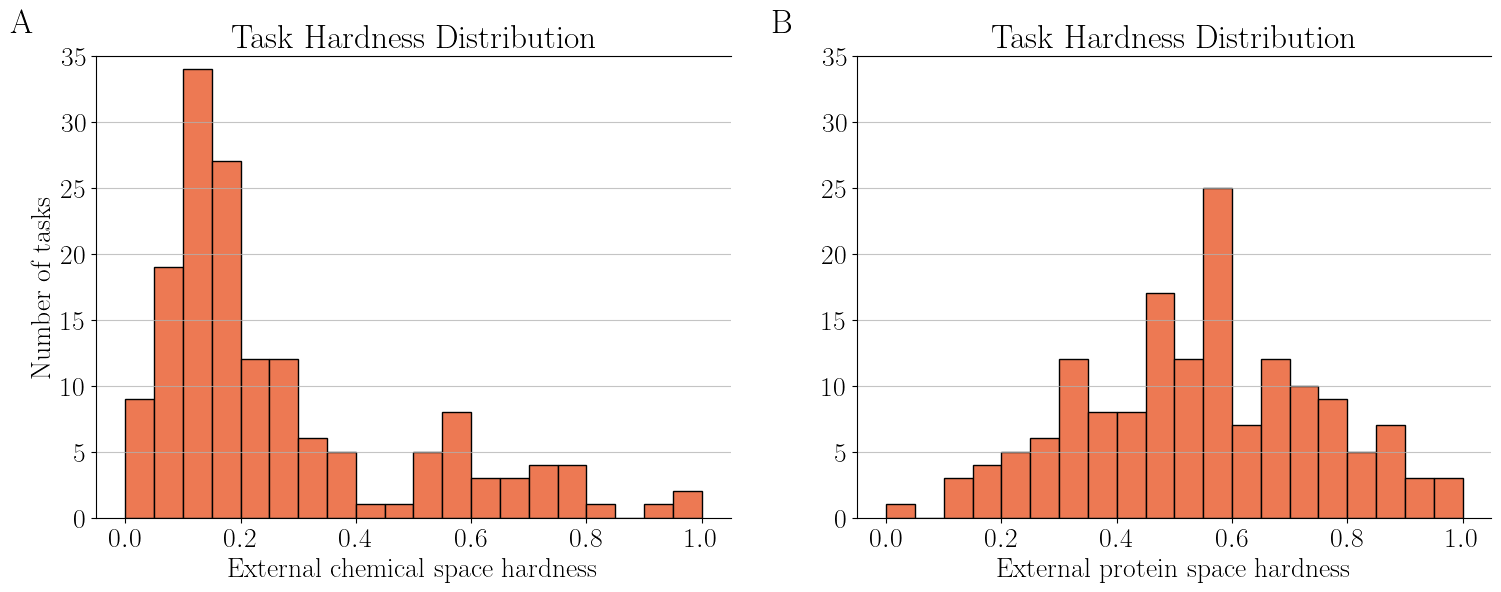

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))
ax0.hist(final_df["hardness_norm"], bins=20, color=light_color, edgecolor=dark_color)
ax1.hist(final_df["protein_hardness_mean_norm"], bins=20, color=light_color, edgecolor=dark_color)

ax0.set_title("Task Hardness Distribution")
ax0.set_xlabel("External chemical space hardness")
ax0.set_ylabel("Number of tasks")
ax0.set_ylim([0, 35])
ax0.text(-0.1, 1.1, "A", transform=ax0.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")
ax0.grid(axis="y", alpha=0.75)
ax0.spines["right"].set_visible(False)


ax1.set_title("Task Hardness Distribution")
ax1.set_xlabel("External protein space hardness")
ax1.set_ylim([0, 35])
ax1.text(-0.1, 1.1, "B", transform=ax1.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")
ax1.grid(axis="y", alpha=0.75)
ax1.spines["right"].set_visible(False)


fig.savefig("assets/EXT_CHEM_EXT_PROT_hist.pdf", transparent=True, backend="pgf", bbox_inches="tight")
plt.show()

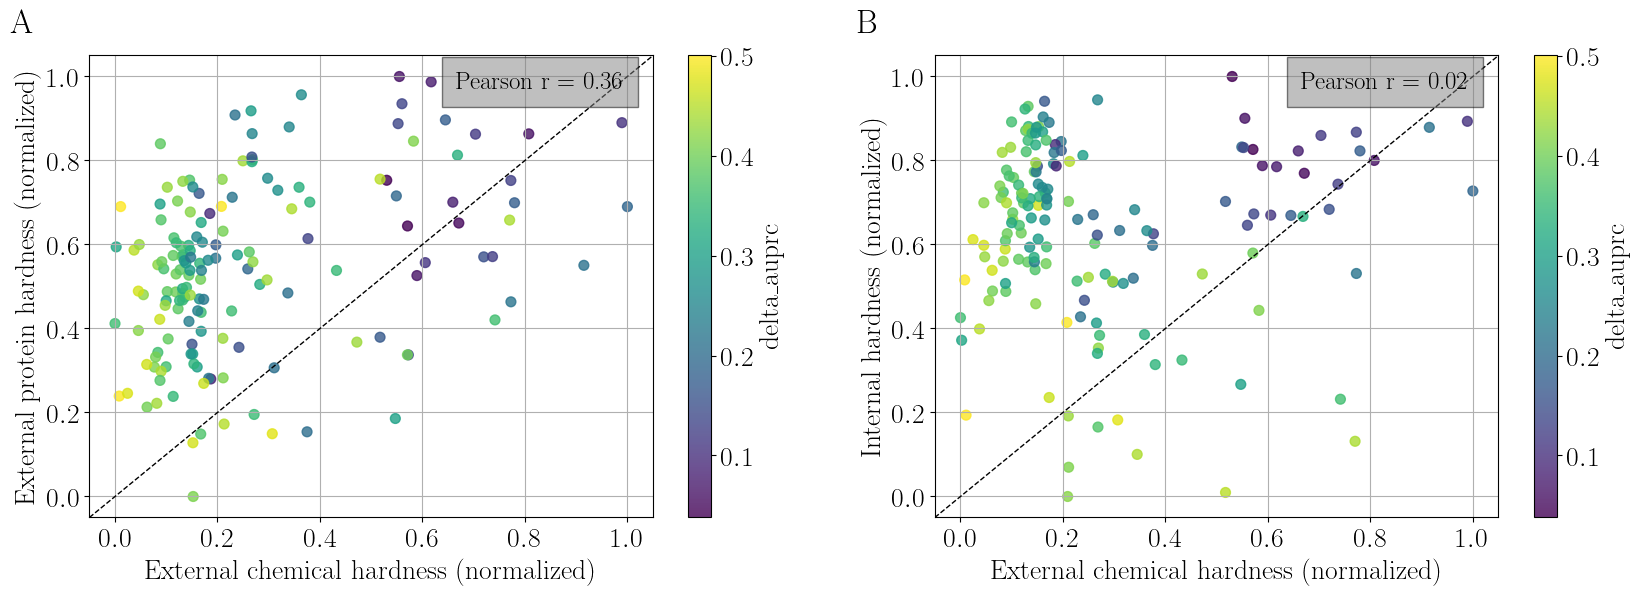

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
final_df.plot.scatter(
    x="hardness_norm",
    y="protein_hardness_mean_norm",
    c="delta_auprc",
    colormap="viridis",
    ax=ax0,
    s=50,
    alpha=0.8,
)

ax0.set_xlabel("External chemical hardness (normalized)")
ax0.set_ylabel("External protein hardness (normalized)")
ax0.grid(True)
ax0.axline((0, 0), slope=1, color="black", linestyle="--", linewidth=1)

corr = round(final_df["hardness_norm"].corr(final_df["protein_hardness_mean_norm"]), 2)
ax0.text(
    0.65,
    0.93,
    "Pearson r = {}".format(corr),
    bbox={"facecolor": "grey", "alpha": 0.5, "pad": 10},
    transform=ax0.transAxes,
    fontsize=18,
)
ax0.text(-0.1, 1.1, "A", transform=ax0.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")

# fig.savefig('assets/hardness_corr.svg', format='svg')

final_df.plot.scatter(
    x="hardness_norm",
    y="internal_hardness_norm",
    c="delta_auprc",
    colormap="viridis",
    ax=ax1,
    s=50,
    alpha=0.8,
)

ax1.set_xlabel("External chemical hardness (normalized)")
ax1.set_ylabel("Internal hardness (normalized)")
ax1.grid(True)
ax1.axline((0, 0), slope=1, color="black", linestyle="--", linewidth=1)

corr = round(final_df["hardness_norm"].corr(final_df["internal_hardness_norm"]), 2)
ax1.text(
    0.65,
    0.93,
    "Pearson r = {}".format(corr),
    bbox={"facecolor": "grey", "alpha": 0.5, "pad": 10},
    transform=ax1.transAxes,
    fontsize=18,
)

# fig.savefig('assets/hardness_corr.svg', format='svg')
ax1.text(-0.1, 1.1, "B", transform=ax1.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")

fig.savefig("assets/hardness_comparisson.pdf", transparent=True, backend="pgf", bbox_inches="tight")
plt.show()

## Correlation between hardenss and performance measure

-0.6272649099569214
-0.3448243586135022
-0.59669707108683
-0.7188987917431473


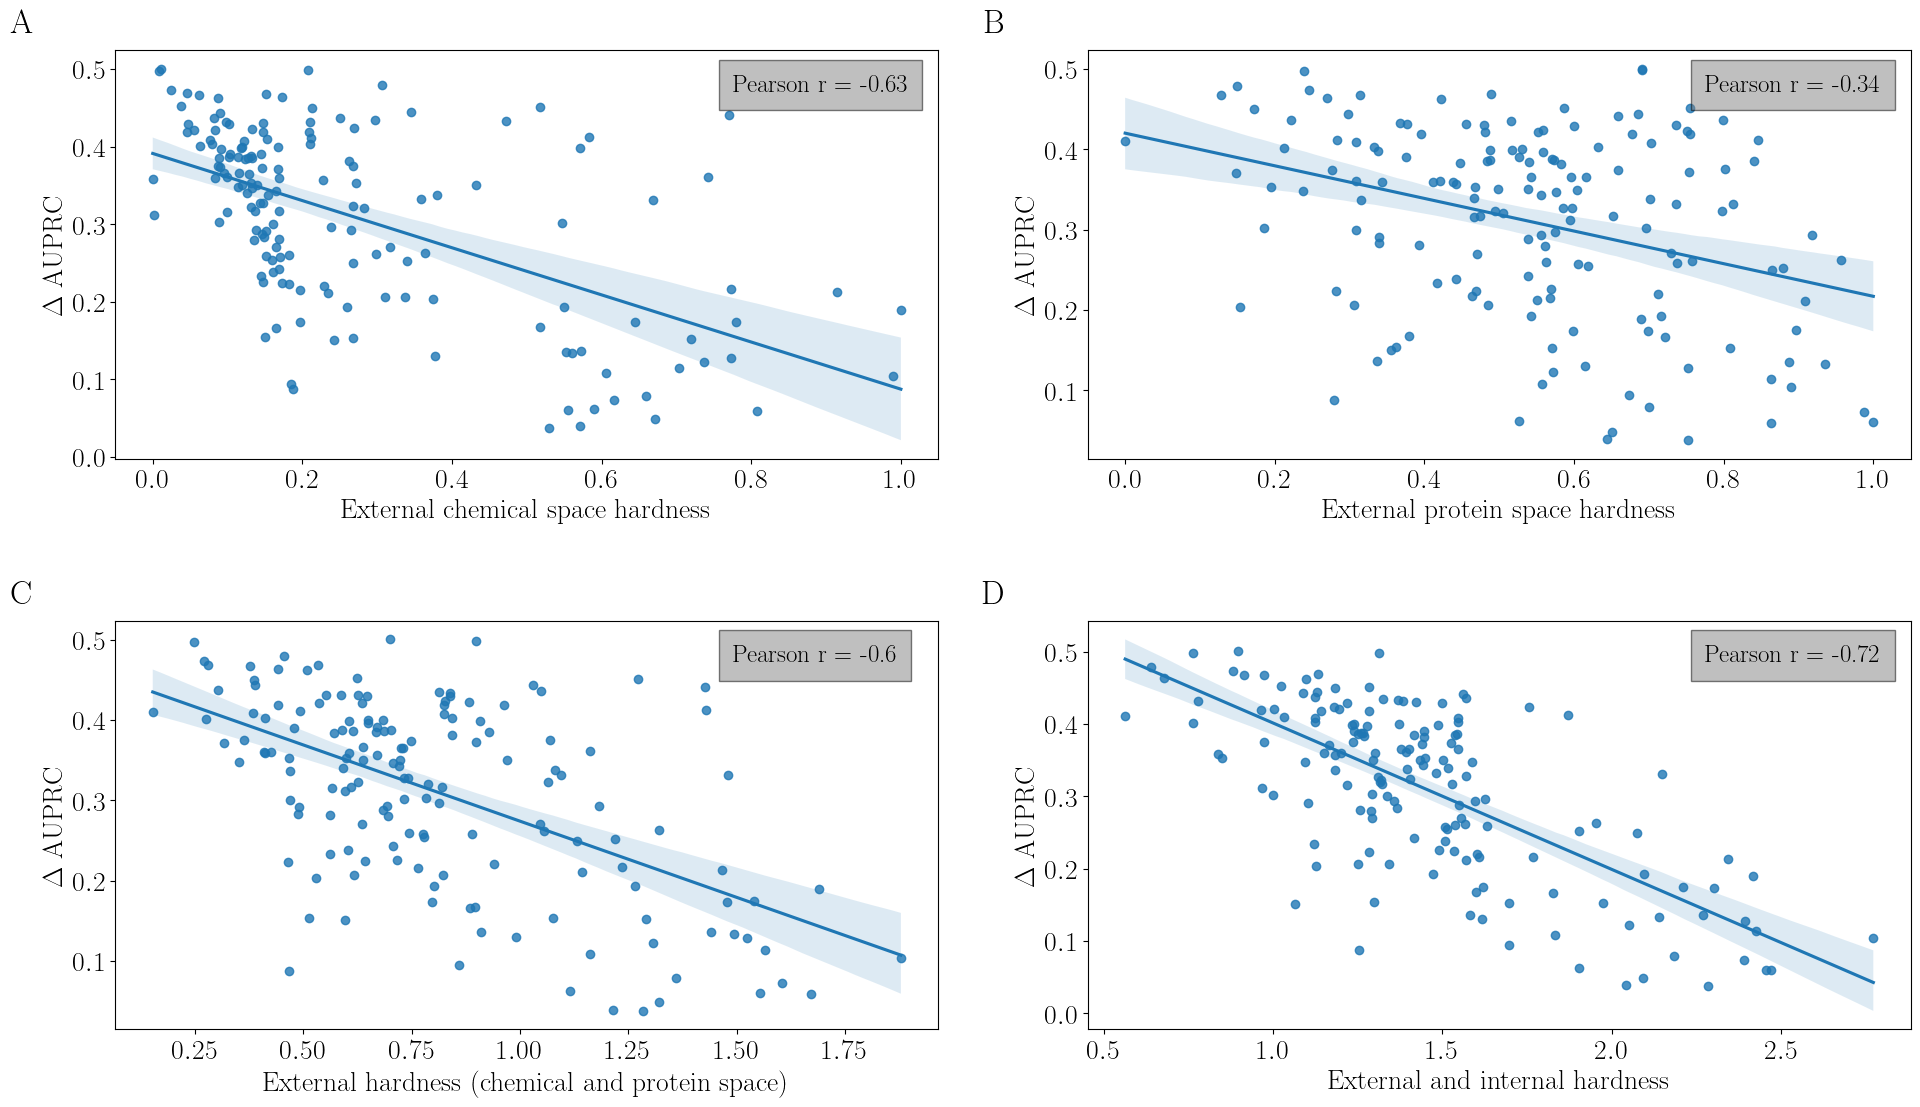

In [20]:
print(final_df["hardness_norm"].corr(final_df["roc_auc"]))
print(final_df["protein_hardness_mean_norm"].corr(final_df["roc_auc"]))
print(final_df["inter_protein_hardness_norm"].corr(final_df["roc_auc"]))
print(final_df["inter_intra_protein_hardness_norm"].corr(final_df["roc_auc"]))

corr1 = round(final_df["hardness_norm"].corr(final_df["roc_auc"]), 2)
corr2 = round(final_df["protein_hardness_mean_norm"].corr(final_df["roc_auc"]), 2)
corr3 = round(final_df["inter_protein_hardness_norm"].corr(final_df["roc_auc"]), 2)
corr4 = round(final_df["inter_intra_protein_hardness_norm"].corr(final_df["roc_auc"]), 2)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 12))
sns.regplot(x="hardness_norm", y="delta_auprc", data=final_df, ax=ax0)
sns.regplot(x="protein_hardness_mean_norm", y="delta_auprc", data=final_df, ax=ax1)
sns.regplot(x="inter_protein_hardness_norm", y="delta_auprc", data=final_df, ax=ax2)
sns.regplot(x="inter_intra_protein_hardness_norm", y="delta_auprc", data=final_df, ax=ax3)


ax0.set(xlabel="External chemical space hardness", ylabel=r"$\Delta$ AUPRC")
ax1.set(xlabel="External protein space hardness", ylabel=r"$\Delta$ AUPRC")
ax2.set(xlabel="External hardness (chemical and protein space)", ylabel=r"$\Delta$ AUPRC")
ax3.set(xlabel="External and internal hardness", ylabel=r"$\Delta$ AUPRC")


ax0.text(
    0.75,
    0.9,
    "Pearson r = {}".format(corr1),
    bbox={"facecolor": "grey", "alpha": 0.5, "pad": 10},
    fontsize=18,
    transform=ax0.transAxes,
)
ax0.text(-0.1, 1.1, "A", transform=ax0.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")


ax1.text(
    0.75,
    0.9,
    "Pearson r = {}".format(corr2),
    bbox={"facecolor": "grey", "alpha": 0.5, "pad": 10},
    fontsize=18,
    transform=ax1.transAxes,
)
ax1.text(-0.1, 1.1, "B", transform=ax1.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")


ax2.text(
    0.75,
    0.9,
    "Pearson r = {}".format(corr3),
    bbox={"facecolor": "grey", "alpha": 0.5, "pad": 10},
    fontsize=18,
    transform=ax2.transAxes,
)
ax2.text(-0.1, 1.1, "C", transform=ax2.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")


ax3.text(
    0.75,
    0.9,
    "Pearson r = {}".format(corr4),
    bbox={"facecolor": "grey", "alpha": 0.5, "pad": 10},
    fontsize=18,
    transform=ax3.transAxes,
)
ax3.text(-0.1, 1.1, "D", transform=ax3.transAxes, fontsize=24, fontweight="bold", va="top", ha="right")


fig.tight_layout(pad=2.0)
fig.savefig("assets/Hardness_vs_ProtoNet.pdf", transparent=True, backend="pgf", bbox_inches="tight")
fig.savefig("assets/Hardness_vs_ProtoNet.svg")
plt.show()